In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
key=scio.loadmat('keyFile.mat')
psdVec=key['psdVec']
psdVec=psdVec.reshape(len(psdVec[0]))
print(psdVec.shape)

(1025,)


In [3]:
# load data
TrainingData = scio.loadmat('TrainingDataTF.mat')
analysisData = scio.loadmat('AnalysisDataTF.mat')

## Preparing
dataY = analysisData['dataVec'][0] # (2048,)
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
Fs = analysisData['sampFreq'][0,0] # 1024

# Search range of phase coefficients
rmin = [40, 1, 1]
rmax = [100, 50, 15]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
t = np.arange(0, nSamples*dt, dt) # (2048,)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
f = np.arange(0, Nyq+df, df) # Not used...(Herb)
[f, pxx1] = welch(TrainingData['trainData'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
pxx=pxx1/2
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

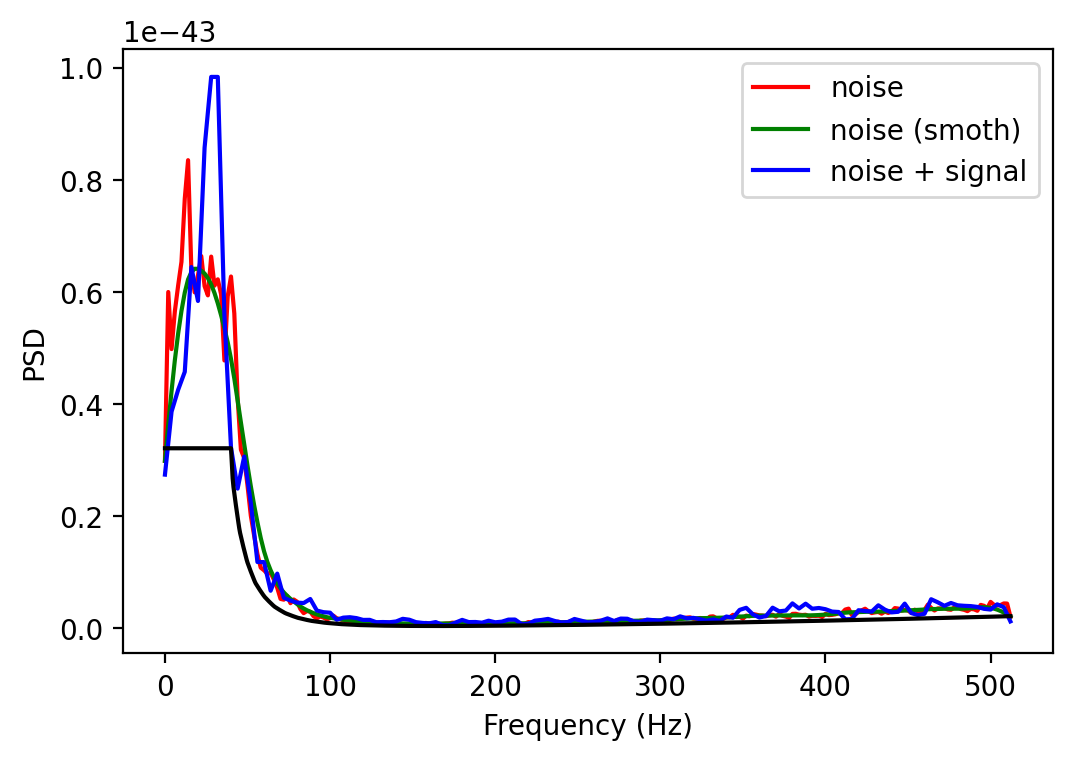

In [4]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx,'r', label='noise')
plt.plot(f,pxxSmth,'g', label='noise (smoth)')
[f_sm, pxxY1] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
pxxY=pxxY1/2
plt.plot(f_sm,pxxY,'b',label='noise + signal')
plt.plot(posFreq,psdVec,'k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
#plt.savefig('output_psd.png', dpi=200)
plt.show()

In [5]:
# Number of independent PSO runs
nRuns = 8

In [6]:
%%time
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    'dataXSq': t**2,
    'dataXCb': t**3,
    'psdPosFreq': psdVec,#psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 72.48it/s]

Wall time: 3min 42s


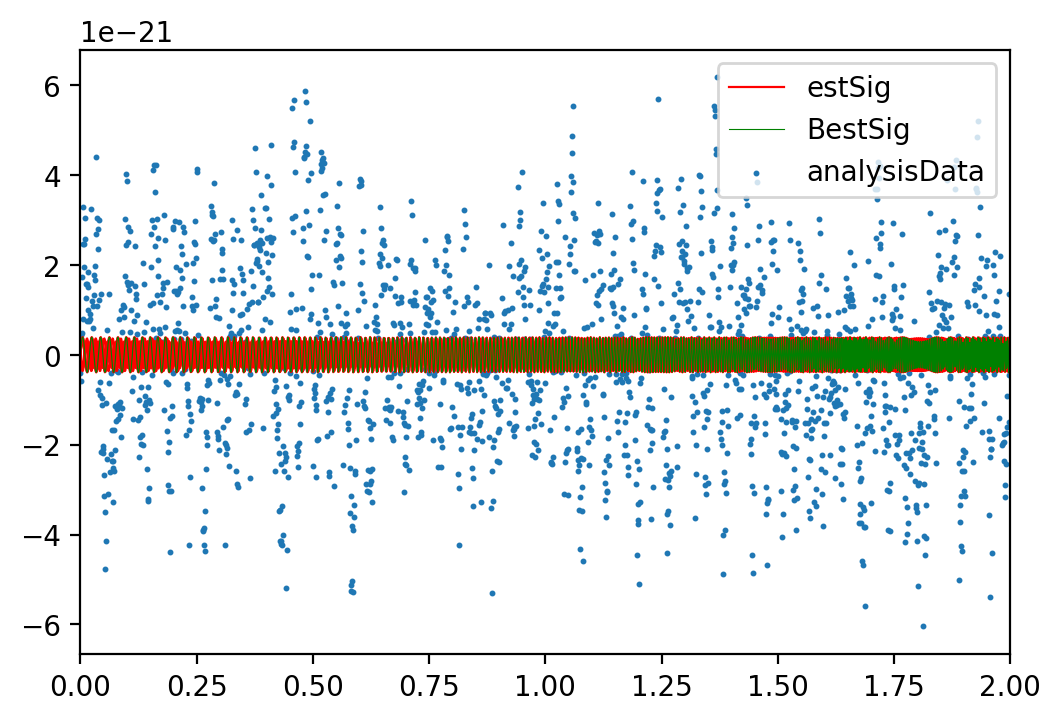

In [7]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color='r', lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         color='g',lw=.2*2)
c.set_label('BestSig')
plt.xlim(0,2)
plt.legend()
plt.savefig('output_sigTF_key.png', dpi=200)
plt.show()

In [8]:
# Print estimated parameters
print('Estimated parameters: a1={}; a2={}; a3={}; SNR={}'.format(outResults['bestQcCoefs'][0],
                                                         outResults['bestQcCoefs'][1],
                                                         outResults['bestQcCoefs'][2],
                                                                outResults['bestSNR']))
for lpruns in range(nRuns):
    print('\nRun No.{}:\nbestFitness={:.2f}'.format(lpruns+1, outStruct[lpruns]['bestFitness']) )
    print('a1={:.4f}; a2={:.4f}; a3={:.4f};SNR={:.4f}'.format(outResults['allRunsOutput'][lpruns]['qcCoefs'][0],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][1],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][2],
                                                  outResults['allRunsOutput'][lpruns]['SNR']))
# Save
np.save('output_resultsTF_key',outResults)
np.save('output_structTF_key',outStruct)

Estimated parameters: a1=50.184504799542154; a2=29.77065230499875; a3=10.056081231750854; SNR=15.473046883118442

Run No.1:
bestFitness=-227.41
a1=49.7757; a2=30.2354; a3=9.9526;SNR=15.0802

Run No.2:
bestFitness=-135.49
a1=53.6674; a2=25.8529; a3=11.4248;SNR=11.6400

Run No.3:
bestFitness=-239.42
a1=50.1845; a2=29.7707; a3=10.0561;SNR=15.4730

Run No.4:
bestFitness=-209.94
a1=49.4541; a2=30.6760; a3=9.8032;SNR=14.4892

Run No.5:
bestFitness=-206.20
a1=51.8933; a2=27.9336; a3=10.6581;SNR=14.3598

Run No.6:
bestFitness=-135.77
a1=44.6653; a2=35.5347; a3=8.2495;SNR=11.6521

Run No.7:
bestFitness=-118.46
a1=61.7048; a2=20.3053; a3=12.5588;SNR=10.8838

Run No.8:
bestFitness=-147.39
a1=56.5441; a2=24.6286; a3=11.3888;SNR=12.1405


In [9]:
readdata=np.load('output_resultsTF_key.npy',allow_pickle=True)
print(readdata)

{'allRunsOutput': [{'fitVal': -227.41222299608668, 'qcCoefs': array([49.77570493, 30.235365  ,  9.95258143]), 'estSig': array([ 0.00000000e+00,  1.15054852e-22,  2.19561436e-22, ...,
        3.80879901e-22, -1.11683460e-22, -3.34809322e-22]), 'totalFuncEvals': 67793.0, 'SNR': 15.080193068926096}, {'fitVal': -135.49042463593932, 'qcCoefs': array([53.66744243, 25.85287892, 11.42475689]), 'estSig': array([ 0.00000000e+00,  9.54908094e-23,  1.80782832e-22, ...,
        2.88671865e-22, -1.26095860e-22, -2.30621540e-22]), 'totalFuncEvals': 67546.0, 'SNR': 11.640035422452087}, {'fitVal': -239.41517984718124, 'qcCoefs': array([50.1845048 , 29.7706523 , 10.05608123]), 'estSig': array([ 0.00000000e+00,  1.18989313e-22,  2.26886417e-22, ...,
        1.25014075e-22,  3.38578994e-22, -2.63543147e-22]), 'totalFuncEvals': 67897.0, 'SNR': 15.473046883118442}, {'fitVal': -209.93693507693806, 'qcCoefs': array([49.4541019 , 30.67600808,  9.80324895]), 'estSig': array([ 0.00000000e+00,  1.09829433e-22,  2

In [10]:
readdata=np.load('output_structTF_key.npy',allow_pickle=True)
print(readdata)

[{'totalFuncEvals': 67793.0, 'bestLocation': array([49.77570493, 30.235365  ,  9.95258143]), 'bestFitness': -227.41222299608668}
 {'totalFuncEvals': 67546.0, 'bestLocation': array([53.66744243, 25.85287892, 11.42475689]), 'bestFitness': -135.49042463593932}
 {'totalFuncEvals': 67897.0, 'bestLocation': array([50.1845048 , 29.7706523 , 10.05608123]), 'bestFitness': -239.41517984718124}
 {'totalFuncEvals': 68102.0, 'bestLocation': array([49.4541019 , 30.67600808,  9.80324895]), 'bestFitness': -209.93693507693806}
 {'totalFuncEvals': 69618.0, 'bestLocation': array([51.89333651, 27.93363809, 10.65807171]), 'bestFitness': -206.20371073562262}
 {'totalFuncEvals': 70938.0, 'bestLocation': array([44.6653441 , 35.5346827 ,  8.24948634]), 'bestFitness': -135.77061652838043}
 {'totalFuncEvals': 68592.0, 'bestLocation': array([61.70477444, 20.30533222, 12.5587711 ]), 'bestFitness': -118.45802604780926}
 {'totalFuncEvals': 69573.0, 'bestLocation': array([56.54406337, 24.62863612, 11.38883022]), 'bes